In [1]:
%load_ext autoreload

%autoreload 2

In [16]:
from utils import MSE,Poisson_reg, sample_PLN, sigmoid 
from utils import logit, log_stirling, build_block_Sigma
from utils import init_Sigma
import matplotlib.pyplot as plt
from pandas import read_csv
import math 
import time 
import pandas as pd 
plt.style.use('ggplot')

import threading
from tqdm import tqdm
import numpy as np
import seaborn as sns 
import torch
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

In [17]:
torch.set_default_dtype(torch.float64)

In [18]:
#get the device. can be used with GPU
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


In [20]:
def show(model,name_doss = '' , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    
    max_ = np.max(np.array(model.ELBO_list))
    print('max ', max_)
    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].legend()
    
    ax[2].plot(abscisse, model.MSE_B_zero_list)
    ax[2].set_title(r'MSE $(B^{0} - \hat {B^{0}})$') 
    ax[2].set_yscale('log')
    ax[2].set_ylim(ymin= 1e-4)
    ax[2].set_ylabel('(b)')
    ax[2].legend()
    
    #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
    length = int(len(abscisse)*0.2)
    ax[3].plot(abscisse[length:], np.array(model.ELBO_list)[length:])#-max_)
    ax[3].set_title('ELBO')
    ax[3].set_ylabel('ELBO')
    ax[3].set_xlabel('Seconds')
    #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
    #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
    #ax[3].set_yscale('symlog')
    ax[3].set_ylabel('(c)')
    ax[3].legend()

    if save : 
        plt.savefig(name_doss)
    plt.show()
    
# show(model_blockwise)

In [21]:
def init_B_zero(Y, covariates): 
    logistic_Y = (Y==0)
    B_zero_init = fit(logistic_Y)
    return B_zero_init


In [22]:
def trunc_log(x,eps = 1e-16):
    y = torch.min(torch.max(x,torch.tensor([eps])), torch.tensor([1-eps]))
    return torch.log(y)



In [13]:
class ZI_PLN():
    def __init__(self, class_optimizer = torch.optim.Rprop, true_value = False): 
        '''
            Initialization. We only define some useful stuff. The intialization of the
            parameters is done int the init_data() function. 
        '''
        self.old_loss = 1
        
        self.class_optimizer = class_optimizer
        
        self.true_value = true_value
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.MSE_B_zero_list = list()
        self.ELBO_list = list()
        self.running_times = list()
        self.cmpt = 0 
        
    def init_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. We 
        also intialize the parameters.
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]

        #model parameter 
        noise = torch.randn(self.p)
        
        poiss_reg = Poisson_reg()
        poiss_reg.fit_torch(self.O,self.covariates,self.Y)
        self.beta = torch.clone(poiss_reg.beta.detach()).to(device)
        #self.beta = torch.zeros(self.d, self.p)
        self.beta.requires_grad_(False)
        
        self.Sigma =  init_Sigma(self.O, self.covariates,self.Y, self.beta).to(device) 
        #self.Sigma =  (torch.diag(noise**2)+ 1e-1).to(device) 
        self.Sigma.requires_grad_(False)#we won't use gradients on Sigma

        self.B_zero = (init_B_zero(self.Y, self.covariates)).to(device) #torch.randn((self.d,self.p)).to(device)
        #self.B_zero = torch.zeros(self.d, self.p)
        if self.true_value : 
            self.beta = torch.clone(true_beta)
            self.Sigma = torch.clone(true_Sigma)
            self.B_zero = torch.clone(true_B_zero)
        self.B_zero.requires_grad_(True)
        
        self.nb_zero = torch.sum(self.Y==0)
        self.dirac = (self.Y==0)
        self.C = torch.cholesky(self.Sigma).to(device)
        #variational parameter
        self.M = self.init_M(300,0.1).to(device)
        #self.M = torch.zeros(self.n, self.p).to(device)
        self.M.requires_grad_(True)
        self.S = torch.randn((self.n,self.p)).to(device)
        self.S.requires_grad_(True)
        self.pi = torch.empty(self.n, self.p).uniform_(0, 1).to(device)*self.dirac
        self.pi.requires_grad_(False)
        
        self.params = {'S' : self.S,'M': self.M, 'beta' : self.beta, 
                       'Sigma' : self.Sigma,'pi': self.pi, 
                       'B_zero': self.B_zero}
        
    def compute_ELBO_ZI(self): 
        return ELBO_ZI(self.Y,self.O,self.covariates, self.M, self.S, self.Sigma, self.beta, self.pi, self.B_zero, self.dirac)
    def ZI_grad_M(self): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        return  torch.multiply(1-self.pi, self.Y-A)-torch.mm((self.M-torch.mm(self.covariates, self.beta)), torch.inverse(self.Sigma))
    def ZI_grad_S(self): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        first = torch.div(1,self.S)
        sec = torch.multiply(torch.multiply(1-self.pi, self.S), A)
        third = torch.mm(self.S,torch.diag(torch.diag(torch.inverse(self.Sigma))))
        return first - sec - third
    
    def ZI_grad_B_zero(self):
        first =  torch.mm(self.covariates.T, self.pi)
        XB_zero = torch.mm(self.covariates, self.B_zero)
        sec = torch.mm(self.covariates.T, sigmoid(XB_zero))
        return first - sec
    
    def ZI_grad_pi(self,pi_): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        XB_zero = torch.mm(self.covariates, self.B_zero)
        return (A + XB_zero -logit(pi_))*self.dirac
    
    def fit(self,Y, O, covariates, tolerance ,Niter,lr,  verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we will
                                call compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        data = [Y,O,covariates]
        self.init_data(data)
        
        optimizer = self.class_optimizer([self.S,self.M, self.B_zero], lr = lr)
        
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < Niter and stop_condition == False: 
            #with torch.no_grad(): 
                
            optimizer.zero_grad()
            loss = -self.compute_ELBO_ZI()
            loss.backward()
            optimizer.step()
            delta = self.old_loss - loss.item() 
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            with torch.no_grad(): 
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
                self.beta = closed_beta(self.covariates,self.M)
                self.pi = closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
                

            # keep track of the error with Sigma. 
            
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
            print('MSE with B_zero', np.round(self.MSE_B_zero_list[-1],5))
                
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)

    def fit_VEM(self,Y, O, covariates, tolerance ,Niter,nb_each_iter, lr,  verbose): 
        self.t0 = time.time()
        data = [Y,O,covariates]
        self.init_data(data)

        for i in range(Niter): 
            self.VE_step(nb_each_iter, 0, 10*lr)
            self.M_step(nb_each_iter, 0, lr)
            closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
    def fit_blockwise(self,Y, O, covariates, tolerance ,Niter,nb_each_iter, lr,  verbose): 
        self.t0 = time.time()
        data = [Y,O,covariates]
        self.init_data(data)
        for i in tqdm(range(Niter)): 
            ## VE step 
            self.update_param(self.M, nb_each_iter, lr)
            self.update_param(self.S, nb_each_iter, lr)
                
            with torch.no_grad(): 
                    self.pi = closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
                    self.keep_records()

            #M step
            self.update_param(self.B_zero, nb_each_iter, lr)
            
            with torch.no_grad(): 
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)#= closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
                self.keep_records()
            print('ELBO :', -self.loss)



    def update_param(self, param, nb_iter, lr): 
        param_optimizer = self.class_optimizer([param], lr = lr)
        param_optimizer.zero_grad()
        for i in range(nb_iter): 
            self.loss = -self.compute_ELBO_ZI()
            self.loss.backward()
            param_optimizer.step()
            param_optimizer.zero_grad()
        self.keep_records()
        return 
            
    def VE_step(self, N_iter_max,tolerance, lr): 
        VE_optimizer = self.class_optimizer([self.M,self.S], lr  = lr)
        VE_optimizer.zero_grad()
        with torch.no_grad():
            self.pi = closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
        crit = 2*tolerance +1
        i = 0
        self.old_M = torch.clone(self.M)
        self.old_S = torch.clone(self.S)
        while i < N_iter_max and crit > tolerance : 
            loss = -self.compute_ELBO_ZI()
            loss.backward()
            VE_optimizer.step()
            VE_optimizer.zero_grad()
            i += 1
            crit = torch.max((torch.norm(self.M-self.old_M))/torch.norm(self.old_M), torch.norm(self.S-self.old_S)/torch.norm(self.old_S))
#             print('ELBO', -loss.item())
#             print('crit :', crit)
            self.old_M = torch.clone(self.M)
            self.old_S = torch.clone(self.S)
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            self.running_times.append(time.time()-self.t0)

            
    def keep_records(self):
        self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
        self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
        self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
        self.ELBO_list.append(-self.loss.item())
        self.running_times.append(time.time()-self.t0)

    def M_step(self, N_iter_max,tolerance, lr): 
        M_optimizer = self.class_optimizer([self.B_zero], lr  = lr)
        M_optimizer.zero_grad()
        with torch.no_grad():
            #pass 
            self.beta = closed_beta(self.covariates,self.M)
            self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)#= closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
        crit = 2*tolerance+1 
        i = 0
        self.old_B_zero = torch.clone(self.B_zero)
        while i < N_iter_max and crit > tolerance : 
            loss = -self.compute_ELBO_ZI()
            loss.backward()
            M_optimizer.step()
            M_optimizer.zero_grad()
            i += 1
            crit = (torch.norm(self.B_zero-self.old_B_zero))/torch.norm(self.old_B_zero)
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            self.running_times.append(time.time()-self.t0)
            #             print('crit :', crit)
            self.old_B_zero = torch.clone(self.B_zero)
        print(' MSE with Sigma : ', np.round(MSE(self.Sigma-true_Sigma),5))
        print(' MSE with beta : ', np.round(MSE(self.beta - true_beta),5))
        print('MSE with B_zero', np.round(MSE(self.B_zero -true_B_zero ).item(),5))

    def init_M(self, N_iter, lr, eps = 7e-3):
        def batch_un_log_posterior(W): 
            return batch_log_P_WgivenY(self.Y, self.covariates, self.O, W, self.C, self.beta) 
        self.batch_un_log_posterior = batch_un_log_posterior
        W = torch.randn(self.n,self.p)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        criterion = 2*eps
        old_W = torch.clone(W)
        keep_condition = True
        for i in tqdm(range(N_iter)):#  i < N_iter and keep_condition: 

            loss = -torch.mean(self.batch_un_log_posterior(W))
            loss.backward()
            optimizer.step()
            crit = torch.max(torch.abs(W-old_W))
            optimizer.zero_grad()
            if crit<eps and i > 2 : 
                keep_condition = False 
            old_W = torch.clone(W)
        print('nb iteration : ', i)
        return W

In [155]:
Y_sampled = torch.tensor(pd.read_csv("Y").values)
O = torch.tensor(pd.read_csv("O").values)
covariates = torch.tensor(pd.read_csv("covariates").values)

M_ = torch.tensor(pd.read_csv("M").values)
S_ = torch.tensor(pd.read_csv("S").values)
pi_ = torch.tensor(pd.read_csv("pi").values)

true_beta = torch.tensor(pd.read_csv("true_beta").values)
true_Sigma = torch.tensor(pd.read_csv("true_Sigma").values)
true_B_zero = torch.tensor(pd.read_csv("true_B_zero").values)

dirac_ = (Y_sampled==0)

ELBO_ZI(Y_sampled,O,covariates, M_, S_, true_Sigma, true_beta, pi_, true_B_zero, dirac_)


tensor(-7577.8900)

In [133]:
def ELBO_ZI(Y,O,covariates, M, S, Sigma, beta, pi, B_zero, dirac): 
    if torch.norm(pi*dirac - pi) > 0.0001: 
        print('Bug')
        return False
    
    n = Y.shape[0]
    p = Y.shape[1]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    XB_zero = torch.mm(covariates, B_zero)
    tmp= n*p/2
    #tmp =  0 
    #pi = ksi_*dirac
    tmp -= n/2*torch.log(torch.det(Sigma))
    tmp += torch.sum(torch.multiply(1-pi,torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2)-log_stirling(Y))  +1/2*torch.log(SrondS))
    tmp += torch.sum(torch.multiply(pi,XB_zero))
    tmp -= torch.sum(torch.log(1+ torch.exp(XB_zero)))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp -= torch.sum(torch.multiply(pi,trunc_log(pi)))
    
    tmp -= torch.sum(torch.multiply(1-pi,trunc_log(1-pi)))
    
    return tmp

def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n,p = M.shape
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0)))

def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)

def closed_pi(O,M,S,dirac, covariates, B_zero): 
    '''
    closed form for pi with the parametrisation centered in Xbeta and variance Sigma
    '''
    A = torch.exp(O+M+torch.multiply(S,S)/2)
    pi_chap = torch.multiply(sigmoid(A+torch.mm(covariates, B_zero)), dirac)
    return pi_chap

In [135]:
Y_sampled = torch.tensor(pd.read_csv("Y").values)
O = torch.tensor(pd.read_csv("O").values)
covariates = torch.tensor(pd.read_csv("covariates").values)
true_beta = torch.tensor(pd.read_csv("true_beta").values)
true_Sigma = torch.tensor(pd.read_csv("true_Sigma").values)
true_B_zero = torch.tensor(pd.read_csv("true_B_zero").values)

model_blockwise = ZI_PLN(true_value = False, class_optimizer = torch.optim.Rprop)
model_blockwise.fit_blockwise(Y_sampled, O, covariates, tolerance = 0 ,Niter = 50,nb_each_iter= 75, lr = 0.05,  verbose = False)

  0%|          | 0/50 [00:00<?, ?it/s]

nb iteration :  299


  2%|▏         | 1/50 [00:00<00:17,  2.79it/s]

ELBO : tensor(-16807.2767, grad_fn=<NegBackward>)


  4%|▍         | 2/50 [00:00<00:17,  2.77it/s]

ELBO : tensor(-6745.6613, grad_fn=<NegBackward>)


  6%|▌         | 3/50 [00:01<00:17,  2.75it/s]

ELBO : tensor(-6583.5676, grad_fn=<NegBackward>)


  8%|▊         | 4/50 [00:01<00:16,  2.76it/s]

ELBO : tensor(-6510.1459, grad_fn=<NegBackward>)


 10%|█         | 5/50 [00:01<00:16,  2.72it/s]

ELBO : tensor(-6464.5649, grad_fn=<NegBackward>)


 12%|█▏        | 6/50 [00:02<00:16,  2.72it/s]

ELBO : tensor(-6435.4661, grad_fn=<NegBackward>)


 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]

ELBO : tensor(-6415.7574, grad_fn=<NegBackward>)


 16%|█▌        | 8/50 [00:02<00:15,  2.71it/s]

ELBO : tensor(-6402.1621, grad_fn=<NegBackward>)


 18%|█▊        | 9/50 [00:03<00:15,  2.69it/s]

ELBO : tensor(-6392.5761, grad_fn=<NegBackward>)


 20%|██        | 10/50 [00:03<00:14,  2.70it/s]

ELBO : tensor(-6384.7508, grad_fn=<NegBackward>)


 22%|██▏       | 11/50 [00:04<00:14,  2.72it/s]

ELBO : tensor(-6377.4740, grad_fn=<NegBackward>)


 24%|██▍       | 12/50 [00:04<00:13,  2.73it/s]

ELBO : tensor(-6371.4404, grad_fn=<NegBackward>)


 26%|██▌       | 13/50 [00:04<00:13,  2.67it/s]

ELBO : tensor(-6366.5452, grad_fn=<NegBackward>)


 28%|██▊       | 14/50 [00:05<00:13,  2.67it/s]

ELBO : tensor(-6362.7987, grad_fn=<NegBackward>)


 30%|███       | 15/50 [00:05<00:13,  2.60it/s]

ELBO : tensor(-6359.6214, grad_fn=<NegBackward>)


 32%|███▏      | 16/50 [00:05<00:12,  2.63it/s]

ELBO : tensor(-6356.8717, grad_fn=<NegBackward>)


 34%|███▍      | 17/50 [00:06<00:12,  2.67it/s]

ELBO : tensor(-6354.7355, grad_fn=<NegBackward>)


 36%|███▌      | 18/50 [00:06<00:11,  2.70it/s]

ELBO : tensor(-6352.9865, grad_fn=<NegBackward>)


 38%|███▊      | 19/50 [00:07<00:11,  2.72it/s]

ELBO : tensor(-6351.4904, grad_fn=<NegBackward>)


 40%|████      | 20/50 [00:07<00:10,  2.73it/s]

ELBO : tensor(-6350.1664, grad_fn=<NegBackward>)


 42%|████▏     | 21/50 [00:07<00:10,  2.66it/s]

ELBO : tensor(-6349.0061, grad_fn=<NegBackward>)


 44%|████▍     | 22/50 [00:08<00:10,  2.69it/s]

ELBO : tensor(-6348.0473, grad_fn=<NegBackward>)


 46%|████▌     | 23/50 [00:08<00:09,  2.72it/s]

ELBO : tensor(-6347.2494, grad_fn=<NegBackward>)


 48%|████▊     | 24/50 [00:08<00:09,  2.71it/s]

ELBO : tensor(-6346.5702, grad_fn=<NegBackward>)


 50%|█████     | 25/50 [00:09<00:09,  2.73it/s]

ELBO : tensor(-6345.9805, grad_fn=<NegBackward>)


 52%|█████▏    | 26/50 [00:09<00:08,  2.72it/s]

ELBO : tensor(-6345.4532, grad_fn=<NegBackward>)


 54%|█████▍    | 27/50 [00:09<00:08,  2.74it/s]

ELBO : tensor(-6344.9670, grad_fn=<NegBackward>)


 56%|█████▌    | 28/50 [00:10<00:08,  2.74it/s]

ELBO : tensor(-6344.4896, grad_fn=<NegBackward>)


 58%|█████▊    | 29/50 [00:10<00:07,  2.75it/s]

ELBO : tensor(-6343.9111, grad_fn=<NegBackward>)


 60%|██████    | 30/50 [00:11<00:07,  2.75it/s]

ELBO : tensor(-6343.2025, grad_fn=<NegBackward>)


 62%|██████▏   | 31/50 [00:11<00:07,  2.63it/s]

ELBO : tensor(-6342.8338, grad_fn=<NegBackward>)


 64%|██████▍   | 32/50 [00:11<00:07,  2.52it/s]

ELBO : tensor(-6342.5290, grad_fn=<NegBackward>)


 66%|██████▌   | 33/50 [00:12<00:06,  2.50it/s]

ELBO : tensor(-6342.2367, grad_fn=<NegBackward>)


 68%|██████▊   | 34/50 [00:12<00:06,  2.52it/s]

ELBO : tensor(-6341.9533, grad_fn=<NegBackward>)


 70%|███████   | 35/50 [00:13<00:05,  2.54it/s]

ELBO : tensor(-6341.6877, grad_fn=<NegBackward>)


 72%|███████▏  | 36/50 [00:13<00:05,  2.58it/s]

ELBO : tensor(-6341.4393, grad_fn=<NegBackward>)


 74%|███████▍  | 37/50 [00:13<00:04,  2.64it/s]

ELBO : tensor(-6341.1954, grad_fn=<NegBackward>)


 76%|███████▌  | 38/50 [00:14<00:04,  2.66it/s]

ELBO : tensor(-6340.9487, grad_fn=<NegBackward>)


 78%|███████▊  | 39/50 [00:14<00:04,  2.68it/s]

ELBO : tensor(-6340.6982, grad_fn=<NegBackward>)


 80%|████████  | 40/50 [00:14<00:03,  2.70it/s]

ELBO : tensor(-6340.3946, grad_fn=<NegBackward>)


 82%|████████▏ | 41/50 [00:15<00:03,  2.66it/s]

ELBO : tensor(-6339.9974, grad_fn=<NegBackward>)


 84%|████████▍ | 42/50 [00:15<00:02,  2.68it/s]

ELBO : tensor(-6339.7851, grad_fn=<NegBackward>)


 86%|████████▌ | 43/50 [00:16<00:02,  2.70it/s]

ELBO : tensor(-6339.6327, grad_fn=<NegBackward>)


 88%|████████▊ | 44/50 [00:16<00:02,  2.72it/s]

ELBO : tensor(-6339.4951, grad_fn=<NegBackward>)


 90%|█████████ | 45/50 [00:16<00:01,  2.74it/s]

ELBO : tensor(-6339.3678, grad_fn=<NegBackward>)


 92%|█████████▏| 46/50 [00:17<00:01,  2.73it/s]

ELBO : tensor(-6339.2487, grad_fn=<NegBackward>)


 94%|█████████▍| 47/50 [00:17<00:01,  2.74it/s]

ELBO : tensor(-6339.1364, grad_fn=<NegBackward>)


 96%|█████████▌| 48/50 [00:17<00:00,  2.74it/s]

ELBO : tensor(-6339.0298, grad_fn=<NegBackward>)


 98%|█████████▊| 49/50 [00:18<00:00,  2.74it/s]

ELBO : tensor(-6338.9281, grad_fn=<NegBackward>)


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]

ELBO : tensor(-6338.8305, grad_fn=<NegBackward>)


In [150]:
pdy = pd.DataFrame(model_blockwise.S.detach().numpy())
#pdy.to_csv('S', header = True, index = False)

#new = pd.read_csv('S')
#new


In [138]:
Y_sampled

tensor([[909,   6,  11,  ...,  14,   0,   0],
        [  0,   0,   0,  ...,   0,   1,  15],
        [  0,   1,   0,  ...,   0,   2,   0],
        ...,
        [  0,   3,   5,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   7,   0,   2],
        [  0,   0,  10,  ...,   0,   0,   0]])

<AxesSubplot:>

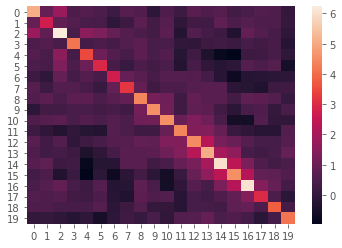

In [130]:
sns.heatmap(model_blockwise.Sigma)

<AxesSubplot:>

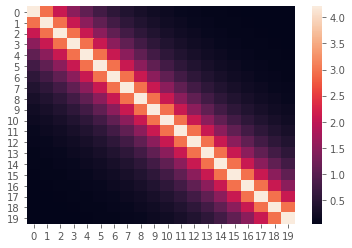

In [131]:
sns.heatmap(true_Sigma)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


max  -6159.465858288999


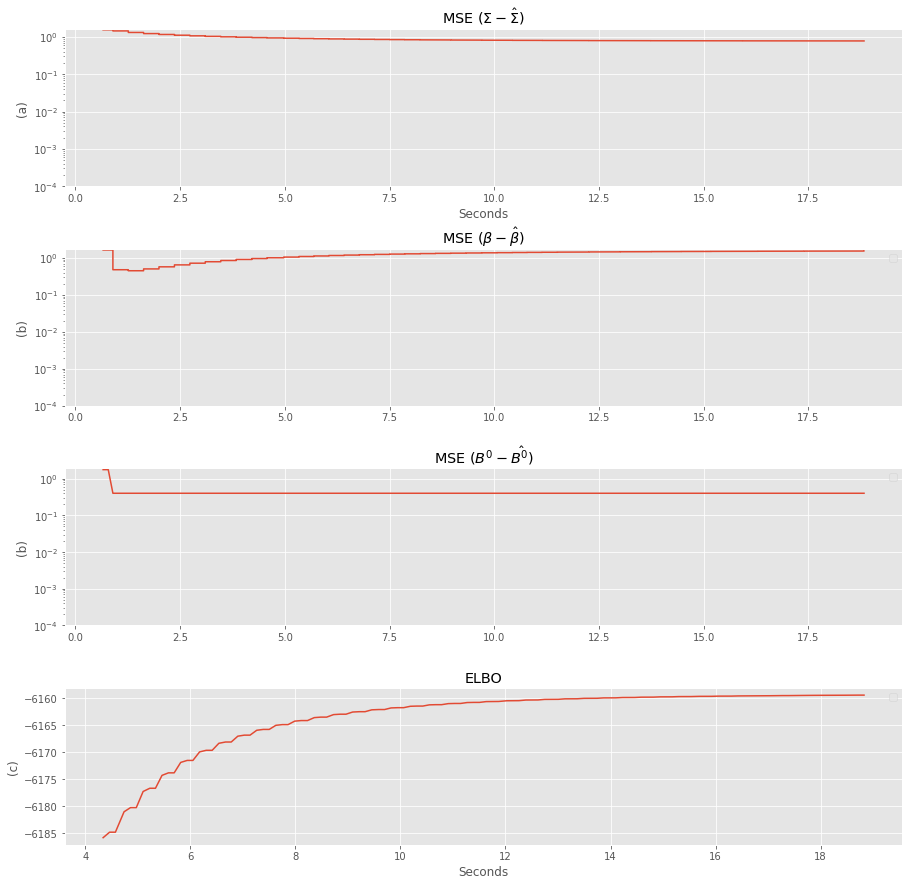

In [132]:
show(model_blockwise)

In [119]:
ZI_cov = covariates@true_B_zero
ksi_ = 1/(1+ np.exp(-ZI_cov))

In [96]:
model_VEM = ZI_PLN(true_value = False, class_optimizer = torch.optim.Rprop)
model_VEM.fit_VEM(Y_sampled, O, covariates, tolerance = 0 ,Niter = 50,nb_each_iter= 5, lr = 0.01,  verbose = False)

100%|██████████| 300/300 [00:00<00:00, 804.58it/s]


nb iteration :  299
MSE beta : tensor(0.6496)
 MSE with Sigma :  tensor(1.8242)
B_zero tensor([[ 1.6787,  0.7554,  1.0716,  0.2066, -0.4597,  1.0068, -0.1487,  0.1596,
          0.9935,  3.0077, -0.1559,  2.0547,  2.1886,  1.1620,  0.5997,  0.7498,
          1.4355, -0.1471,  1.0242,  0.2588],
        [-0.3418,  0.2446, -1.6227,  1.1836,  1.8435, -0.4737,  0.4865,  0.4263,
         -0.9371,  1.8152,  2.0248,  0.7378,  2.2282,  3.5836,  1.0101,  0.1602,
          0.7600,  1.5444, -0.0534,  1.2534]], requires_grad=True)
 MSE with beta :  tensor(0.6496)
MSE with B_zero 1.17742
MSE beta : tensor(0.4809)
 MSE with Sigma :  tensor(1.6502)
B_zero tensor([[ 1.6042,  0.6810,  0.9972,  0.1322, -0.5341,  0.9324, -0.2232,  0.0852,
          0.9191,  2.9333, -0.2303,  1.9803,  2.1142,  1.0876,  0.5253,  0.6754,
          1.3611, -0.2215,  0.9498,  0.1844],
        [-0.4162,  0.1701, -1.6971,  1.1091,  1.7691, -0.5481,  0.4121,  0.3519,
         -1.0116,  1.7408,  1.9504,  0.6634,  2.1538,  3.5092, 

 MSE with Sigma :  tensor(0.8208)
B_zero tensor([[ 1.0197,  0.2801,  0.0869, -0.2902, -0.2070,  0.9607, -1.2235, -0.4290,
          0.5823,  2.7359,  0.1957,  2.1575,  1.9572,  0.8918,  0.2901,  0.0176,
          0.8045, -0.5838,  0.5857,  0.0922],
        [-0.1991, -0.1070, -2.7390,  0.7972,  1.1148, -1.1392, -0.0991,  0.3797,
         -1.3670,  1.8652,  1.5489,  0.4012,  1.9362,  3.4242,  0.4732, -0.5924,
          0.7670,  1.2535, -0.4228,  0.8695]], requires_grad=True)
 MSE with beta :  tensor(0.5907)
MSE with B_zero 0.74946
MSE beta : tensor(0.5981)
 MSE with Sigma :  tensor(0.8184)
B_zero tensor([[ 1.0272,  0.2726,  0.0951, -0.3338, -0.2145,  0.9532, -1.2527, -0.4450,
          0.5531,  2.7284,  0.2032,  2.1657,  1.9562,  0.8928,  0.2813,  0.0088,
          0.7885, -0.5998,  0.5697,  0.0847],
        [-0.2001, -0.1145, -2.8134,  0.8254,  1.1073, -1.1467, -0.0909,  0.3709,
         -1.3588,  1.8662,  1.5479,  0.3852,  1.9352,  3.4252,  0.4644, -0.6012,
          0.7752,  1.2545, -

 MSE with Sigma :  tensor(0.8319)
B_zero tensor([[ 1.1472,  0.3687,  0.4618, -0.7395, -0.2882,  0.8673, -1.3227, -0.6292,
         -0.0088,  2.7192,  0.2140,  2.2289,  1.8531,  0.8042,  0.3045,  0.1816,
          0.7055, -0.7163,  0.4825, -0.0640],
        [-0.1651, -0.1550, -3.4032,  1.1851,  1.1507, -1.0029, -0.0528,  0.3945,
         -1.0596,  1.9097,  1.5544,  0.2737,  1.9001,  3.3536,  0.3706, -0.9675,
          0.8020,  1.2865, -0.3164,  0.7617]], requires_grad=True)
 MSE with beta :  tensor(0.6903)
MSE with B_zero 0.7935
MSE beta : tensor(0.6944)
 MSE with Sigma :  tensor(0.8352)
B_zero tensor([[ 1.1547,  0.3762,  0.4608, -0.7605, -0.2872,  0.8663, -1.3237, -0.6282,
         -0.0163,  2.7182,  0.2130,  2.2299,  1.8541,  0.7967,  0.3055,  0.2098,
          0.7045, -0.7153,  0.4815, -0.0715],
        [-0.1576, -0.1560, -3.4042,  1.2011,  1.1517, -0.9954, -0.0538,  0.3955,
         -1.0586,  1.9087,  1.5619,  0.2747,  1.9011,  3.3461,  0.3631, -1.0111,
          0.8095,  1.2875, -0

In [110]:
d = 2 # nb of cavariates
n = 200; p = 20

In [111]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = torch.from_numpy(build_block_Sigma(p,20)).to(device)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p).to(device)

covariates = torch.rand((n,d))/1
O = 0+torch.zeros((n,p))
true_B_zero = torch.randn((d,p)).to(device)
sample_model = sample_PLN(ZI = True)
Y_sampled, Z_sampled, ksi  = sample_model.sample(true_Sigma.to(torch.device('cpu')),true_beta.to(torch.device('cpu')), O, covariates, true_B_zero)
try : 
    ksi = torch.from_numpy(ksi)
except : 
    pass

Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

In [9]:
def log_p_ksi(B_zer,ksi): 
    XB_zer = torch.mm(covariates, B_zer)
    return torch.sum(torch.multiply(ksi,XB_zer)- torch.log(1+ torch.exp(XB_zer)))

# B_init = torch.randn((d,p))


In [10]:
def fit(ksi): 
    B_zer = torch.randn((d,p), requires_grad = True)
    optim = torch.optim.Rprop([B_zer], lr = 0.1)
    for i in range( 100): 
        loss = - log_p_ksi(B_zer,ksi)
        loss.backward()
        optim.step()
        optim.zero_grad()
        #print('MSE :', MSE(B_zer-true_B_zero))
    return B_zer  
# B_zer = fit(ksi)

In [11]:
def batch_log_P_WgivenY(Y_b, covariates_b, O_b, W, C, beta): 
    length = len(W.shape)
    if length == 2 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
    elif length == 3 : 
        CW = torch.matmul(C.unsqueeze(0).unsqueeze(1), W.unsqueeze(3)).squeeze()
    A_b = O_b + CW + covariates_b@beta
    return -1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_b)   + A_b*Y_b - log_stirling(Y_b) , axis = -1)
